Assignment 3

In [1]:
import pickle 
import numpy as np
import torch
import torch.nn as nn 
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

with open("/Users/hectorteyssier/Downloads/comp-551-fall-2021/labels_l.pkl", 'rb') as f: 
    label = pickle.load(f)

with open("/Users/hectorteyssier/Downloads/comp-551-fall-2021/images_l.pkl", 'rb') as f: 
    images_l = pickle.load(f)

with open("/Users/hectorteyssier/Downloads/comp-551-fall-2021/images_test.pkl", 'rb') as f: 
    test_images = pickle.load(f)

(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x1046bc3a0>)

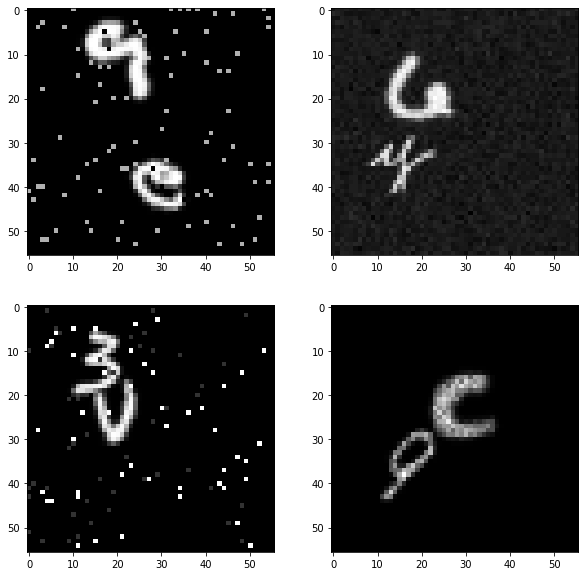

In [2]:
# We visualize some of the images from the dataset

plt.figure(figsize=(10,10))
plt.subplot(221), plt.imshow(images_l[0], cmap='gray')
plt.subplot(222), plt.imshow(images_l[25], cmap='gray')
plt.subplot(223), plt.imshow(images_l[50], cmap='gray')
plt.subplot(224), plt.imshow(images_l[4783], cmap='gray')

In [3]:
# https://www.analyticsvidhya.com/blog/2019/10/building-image-classification-models-cnn-pytorch/

In [4]:
# We create training set, label for training set and test set numpy array. 
X_training = images_l
y_training = label
X_test = test_images

print(y_training.shape)
print(X_training.shape)
print(X_test.shape)

(30000, 36)
(30000, 56, 56)
(15000, 56, 56)


In [5]:
# We create a validation set
X_training, X_val, y_training, y_val = train_test_split(X_training, y_training, test_size = 0.1)
(X_training.shape, y_training.shape), (X_val.shape, y_val.shape)

(((27000, 56, 56), (27000, 36)), ((3000, 56, 56), (3000, 36)))

In [6]:
# We now convert the data to torch format

X_training = X_training.reshape(27000, 1, 56, 56)
X_training = torch.from_numpy(X_training)
y_training = torch.from_numpy(y_training)

X_val = X_val.reshape(3000, 1, 56, 56)
X_val = torch.from_numpy(X_val)
y_val = torch.from_numpy(y_val)

X_test = X_test.reshape(15000, 1, 56, 56)
X_test = torch.from_numpy(X_test)

In [7]:
# We define a neural network with:
# - 2 convolutional layers 
# - 3 linear layers 

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16 * 12 * 12, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 36)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net()

In [8]:
# We test the net with a random input of the same shape as the data
input = torch.randn(1, 1, 56, 56)
out = net(input)
print(out)

tensor([[ 0.0025,  0.0194,  0.0355, -0.0459,  0.0099,  0.0266, -0.0046, -0.0554,
          0.0517,  0.0487, -0.0992,  0.0524, -0.0806,  0.1368, -0.0543,  0.0184,
          0.0828, -0.0306, -0.1319, -0.0173, -0.0873,  0.0200, -0.0949,  0.0530,
         -0.1362, -0.0758,  0.0688,  0.1204, -0.0434,  0.0894, -0.0549,  0.0761,
         -0.0671, -0.0209,  0.0749,  0.0093]], grad_fn=<AddmmBackward0>)


In [9]:
# We set the net to work with float values, and print its characteristic
net = net.float()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=2304, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=36, bias=True)
)


In [10]:
# We set the loss and the gradient method used during training the net 
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


This is a try of implementation for bootstrap (i.e. with batches).
We get an accuracy of 2.8% on the validation set...

NOTE: Either run the following block (i.e. bootrap implementation) or the one after (no bootstrap) as they each fit the model differently. 

In [13]:
# for vizualization
train_losses = []
val_losses = []

BATCH_SIZE = 5

for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    # we go over all batches in the dataset
    for i in range(int(len(X_training)/BATCH_SIZE)):
        # zero the parameter gradients
        optimizer.zero_grad()

        X_training_batch = X_training[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
        y_training_batch = y_training[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
        # print(X_training_batch.shape)
        # print(y_training_batch.shape)

        # forward
        outputs_train = net(X_training_batch.float())

        # computing the loss
        loss_train = criterion(outputs_train, y_training_batch)

        # backward
        loss_train.backward()
        optimizer.step()

        running_loss += loss_train.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 6.451
[1,  4000] loss: 6.395
[2,  2000] loss: 6.284
[2,  4000] loss: 6.245
[3,  2000] loss: 6.157
[3,  4000] loss: 6.099
[4,  2000] loss: 6.058
[4,  4000] loss: 6.014
[5,  2000] loss: 5.996
[5,  4000] loss: 5.944
Finished Training


This is an implementation where we give the whole dataset at once, without batches. 
We get an accuracy of 0.43%...

In [302]:
# for vizualization  
train_losses = []
val_losses = []

for epoch in range(5):  # loop over the dataset multiple times
    
    # zero the parameter gradients
    optimizer.zero_grad()

    # forward
    outputs_train = net(X_training.float())
    outputs_val = net(X_val.float())
    
    # computing the loss
    loss_train = criterion(outputs_train, y_training)
    loss_val = criterion(outputs_val, y_val)

    # storing losses for visualization 
    train_losses.append(loss_train.item())
    val_losses.append(loss_val.item())

    # backward 
    loss_train.backward()
    optimizer.step()
    
    # printing the validation loss
    print('Epoch : ',epoch+1, '\t', 'loss :', loss_val.item())

print('Finished Training')

Epoch :  1 	 loss : 8.32755669405063
Epoch :  2 	 loss : 7.710823444912831
Epoch :  3 	 loss : 7.45959378683567
Epoch :  4 	 loss : 7.337975174546242
Epoch :  5 	 loss : 7.262604270736376
Finished Training


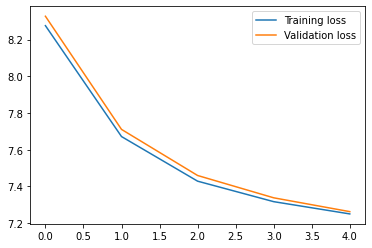

In [303]:
# Vizualising the data
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.show()

In [24]:
# Computing accuraccy for the validation set
def get_clean_labels(raw_outputs, verbose=False):

    dataset_size, label_number = raw_outputs.shape
    clean_outputs = np.zeros((dataset_size,label_number))

    # Separating letters from digits in two arrays
    digit_label_raw = raw_outputs[:,0:10]
    letter_label_raw = raw_outputs[:,10:36]
    
    
    # Applying a softmax on the arrays
    digit_softmax = torch.exp(digit_label_raw)
    letter_softmax = torch.exp(letter_label_raw)
    

    prob_digit = list(digit_softmax.numpy())
    prob_letter = list(letter_softmax.numpy())
    # print(prob_digit[5])
    # print(len(prob_digit[5]))

    # Selecting the max argument for the digit array and for the letter array
    digit_index = np.argmax(prob_digit, axis=1)
    letter_index = np.argmax(prob_letter, axis=1)
    
    # building a clean output 
    for i in range(dataset_size):
        clean_outputs[i,digit_index[i]] = 1.0
        clean_outputs[i,10+letter_index[i]] = 1.0
        
    if(verbose):
        print("Raw:")
        print(raw_outputs[5])
        print("----------------")

        print("Raw Digit:")
        print(digit_label_raw[5])
        print(digit_label_raw.shape)
        print("Raw Letter:")
        print(letter_label_raw[5])
        print(letter_label_raw.shape)
        print("----------------")

        print("Softmax Digit:")
        print(digit_softmax[5])
        print(digit_softmax.shape)
        print("Softmax Letter:")
        print(letter_softmax[5])
        print(letter_softmax.shape)
        print("----------------")

        print("Index Digit:")
        print(digit_index[5])
        print("Index Letter:")
        print(letter_index[5])
        print("----------------")

        print("Clean out")
        print(clean_outputs[5])

    return clean_outputs


# passing validation set in the network
with torch.no_grad():
    output = net(X_val.float())

results = get_clean_labels(output)

print("Accuracy of the net on the validation set: "+str(accuracy_score(y_val, results)*100)+"%")


Accuracy of the net on the validation set: 2.8000000000000003%


In [28]:
# passing validation set in the network
with torch.no_grad():
    output = net(X_training.float())

results = get_clean_labels(output)

print("Accuracy of the net on the validation set: "+str(accuracy_score(y_training, results)*100)+"%")

Accuracy of the net on the validation set: 7.962962962962964%


In [30]:
import csv

with torch.no_grad():
    output = net(X_test.float())

clean_outputs = get_clean_labels(output)

header = ['# Id', 'Category']

with open('submission.csv', 'w', encoding='UTF8') as f:
    writer = csv.writer(f)

    writer.writerow(header)

    for i in range(len(clean_outputs)):
        label = ""
        for d in clean_outputs[i]:
            label += str(int(d))

        data = []
        data.append(i)
        data.append(label)
        
        writer.writerow(data)